# Self Driving Car 
## Convolutional Neural Network (CNN)
This project is to develop a Behavioural Bloning SDC using a deep neural network 

### System Pipeline Overview
<ul>
<li>Data Collection</li>
<li>Data Augmentation</li>
<li>Data Preprocess</li>
<li>Define the Model</li>
<li>Train the Model</li>
<li>Test the Model</li>
</ul>

In [1]:
# Necessary imports
import numpy as np
import random
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

## 1. Data Collection
The driving information was collected in a simulated environment to make it easy to record all the car controls and the environment the car sees infront of it through 3 cameras. The car was driven around two tracks in the simulator multiple times and in different directions or focusing on different parts to collect a balanced and varied data so that the neural network will be able to handle many different situations.

In [2]:
track_log_path = ['jungleTrack', 'lsdTrack','ernanDriving','lsdTrack-2','jungleTrack-2','jungleTrack-3']
#track_log_path = ['ernanDriving']

#select correct column for csv
columns = ['centre cam', 'left cam' , 'right cam ', 'steering', 'throttle', 'brake', 'speed']

def parse_logs(track_log_path):
    '''
    Parse the driving logs, customise the image paths and concatenate all the logs in a single Pandas
    DataFrame
    :params log_paths: List of all the driving log paths
    :return: Pandas DataFrame
    '''
    frames = []
    for i, track_log_path in enumerate(track_log_path):
        df = pd.read_csv(track_log_path + '/driving_log.csv')
        global columns
        df.columns = columns
        
        for column in columns[:3]:
            df[column] = df[column].apply(lambda x: '/'.join(x.split('/')[-3:]))

        frames.append(df)
    return pd.concat(frames, ignore_index=True)

df = parse_logs(track_log_path)
image = cv2.imread(df.loc[0]['centre cam'].strip())

In [3]:
def progress(count, total, status=''):
    bar_len = 40
    filled_len = int(round(bar_len * count / float(total)))

    percents = round(100.0 * count / float(total), 1)
    bar = '=' * filled_len + '-' * (bar_len - filled_len)

    print('[%s] %s%s ...%s\r' % (bar, percents, '%', status))
    return


print('Number of scene frames: {} /20,000'.format(len(df)))
progress(len(df),20000,"Data Collection Progress")
print('\nIdeally we want a sample set of about 20,00 for balance and variety')
print('Total frames Left,Right and Centre prespectives): {} /60,000'.format(len(df) * 3))
print('Image shape: {}'.format(image.shape))

Number of scene frames: 14814 /20,000
[==============================----------] 74.1% ...Data Collection Progress

Ideally we want a sample set of about 20,00 for balance and variety
Total frames Left,Right and Centre prespectives): 44442 /60,000
Image shape: (160, 320, 3)


Avg # samples/bin: 592.56
Threshold 711


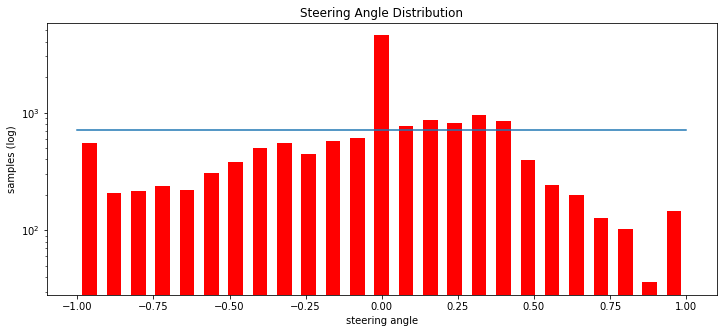

In [4]:
# Visualising the steering angle distribution

#size of steering angle bins
binSize = 25 

hist, bins = np.histogram(df.steering, binSize)
center = (bins[:-1] + bins[1:])/2

plt.figure(figsize=(12,5))
plt.bar(center, hist, align='center', width=(bins[0] - bins[1])*0.6, log=True, fc='r', color='b')
plt.title('Steering Angle Distribution')
plt.ylabel('samples (log)')
plt.xlabel('steering angle')
avg_nb_samples = len(df['steering']) / binSize

#we want the threshold to be a bit above the average number of samples
threshold = int(avg_nb_samples * 1.2)
plt.plot((df['steering'].min(), df['steering'].max()), (threshold, threshold))

print('Avg # samples/bin: {}'.format(avg_nb_samples))
print('Threshold {}'.format(threshold))

## Description:
This is a graph of the steering angle recorded for each frame during a drive around the simulator. The Data is skewed towards the center which will give our neural network poor learning material. Balance and variety are very important to sufficiently train our model.
Reasons for skewed data: 
<ul>
<li>Track: This course contains a lot of straights or gently turns meaning it doesn't require as many extreme steering angles</li>
<li>Sample Size: If the data is from one lap, around one track, in one direction for example. To accomplish a more balanced sample set we will need to record multiple laps on different tracks and in different directions</li>
<li>Specialisation: We may want to record particular turns or environments multiple times such as sharp bends. It would have undoubtedly helped balance out the data in this case.</li>
<li>Data Selection: This is the whole set of data recorded is very skewed towards the center because the tracks contain many straights. We could how ever decide to purposely omit data, such as the large number of low steering angles, to have a more balanced training set </li>
</ul>

In the graph above I have marked the cut off point above which I will discard any more data. This will give a more balanced data set.


Amount of data in each bin above(+) or below(-) the threshold
[-157 -505 -494 -473 -490 -406 -329 -214 -158 -264 -136  -99 3813   51  156
   99  235  135 -314 -467 -511 -584 -609 -675 -565]
Recordes removed from Bin: 12
Recordes removed from Bin: 13
Recordes removed from Bin: 14
Recordes removed from Bin: 15
Recordes removed from Bin: 16
Recordes removed from Bin: 17

Length of the dataset post cleanup: 10325


Text(0.5,0,'steering angle')

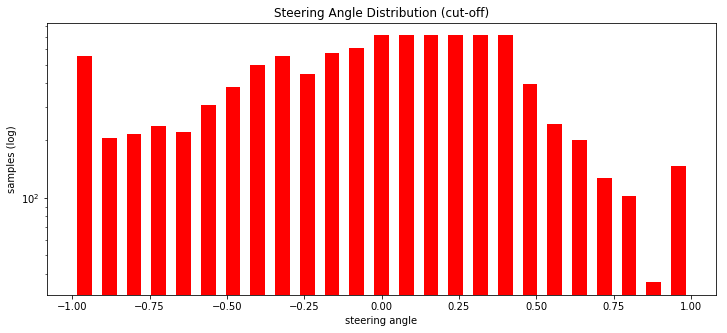

In [5]:
# Dataset cleanup
# find the values above the threshold
above_threshold = hist - threshold
print("Amount of data in each bin above(+) or below(-) the threshold")
print(above_threshold)
to_delete = []


for i in range(len(above_threshold)):
    if above_threshold[i] > 0:
        print("Recordes removed from Bin: {0}".format(i))
        # if the values in a bin are above the threshold remove them from the data set
        idxs = np.where(np.logical_and(df['steering'] >= bins[i], df['steering'] < bins[i+1]))[0]
        # picks a random entry from the correct range of values to remove 
        choices = idxs[np.random.choice(len(idxs), above_threshold[i], replace=False)]
        to_delete.extend(choices)
        
# delete the chosen entires from the data set
df = df.drop(to_delete).reset_index(drop=True)

print('\nLength of the dataset post cleanup: {}'.format(len(df)))

# Plot the new distribution of the steering angles
plt.figure(figsize=[12,5])
plt.hist(df['steering'], 25, rwidth=0.6, align='mid', histtype='bar', log=True, fc='r', color='b')
plt.title('Steering Angle Distribution (cut-off)')
plt.ylabel('samples (log)')
plt.xlabel('steering angle')


centre cam    C:\Users\Roble\Desktop\SelfDrivingCar\Behaviou...
left cam      C:\Users\Roble\Desktop\SelfDrivingCar\Behaviou...
right cam     C:\Users\Roble\Desktop\SelfDrivingCar\Behaviou...
steering                                             -0.0994917
throttle                                                      1
brake                                                         0
speed                                                   30.1885
Name: 2018, dtype: object

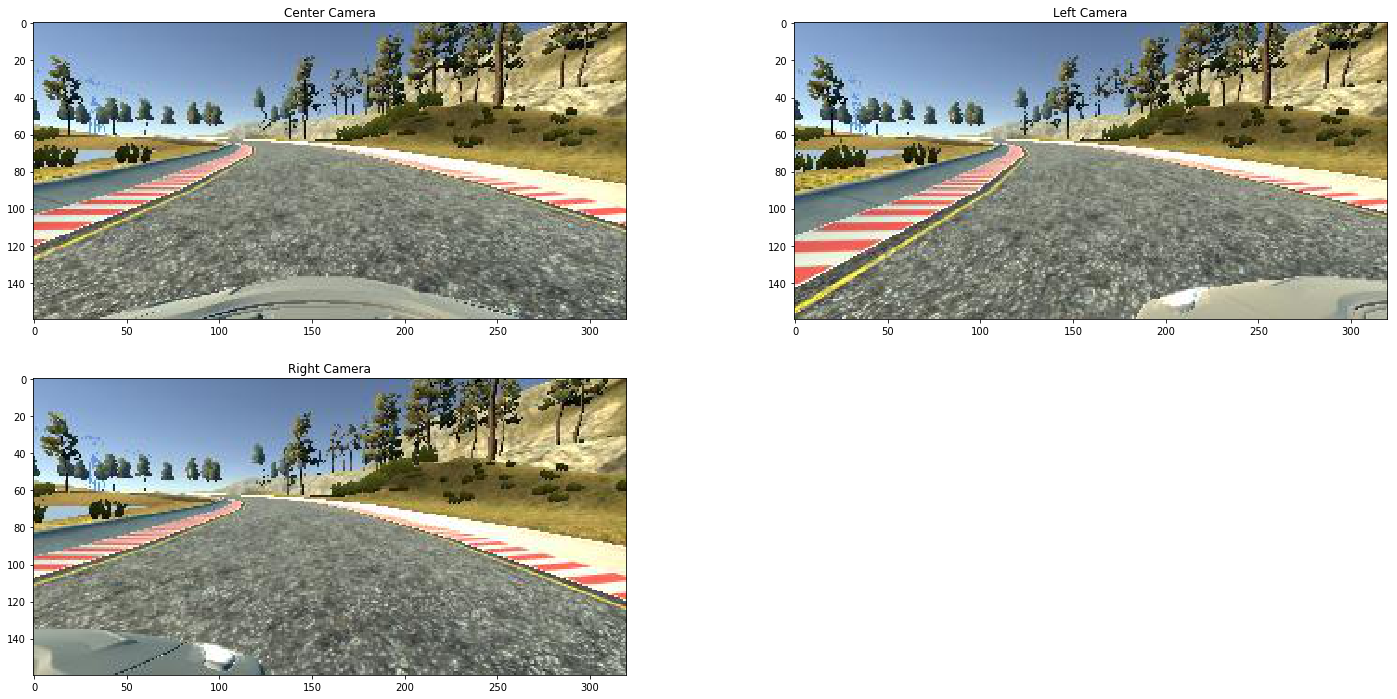

In [6]:
# select a random entry in the data
recordEntry=2018

plt.subplots(figsize=(25, 12))
titles = ['Center', 'Left', 'Right']
for i in range(3):
    image = cv2.imread(df.loc[recordEntry][i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.subplot(2, 2, i+1)
    plt.title(titles[i] + ' Camera')
    plt.imshow(image)

df.loc[recordEntry]

## 1. Data Augmentation
We have a lot of data collected but we still always use more data for our neural network, data augmentation will allow us to create lots of new data from our existing data. It will also allow us simulate lots of situations that would take a lot longer to simulate than it would to adjust our current data to emulate these situations. Different turns, lighting conditions (brightness) and positions on the road.

Text(0.5,1,'Flipped Image (right cam)')

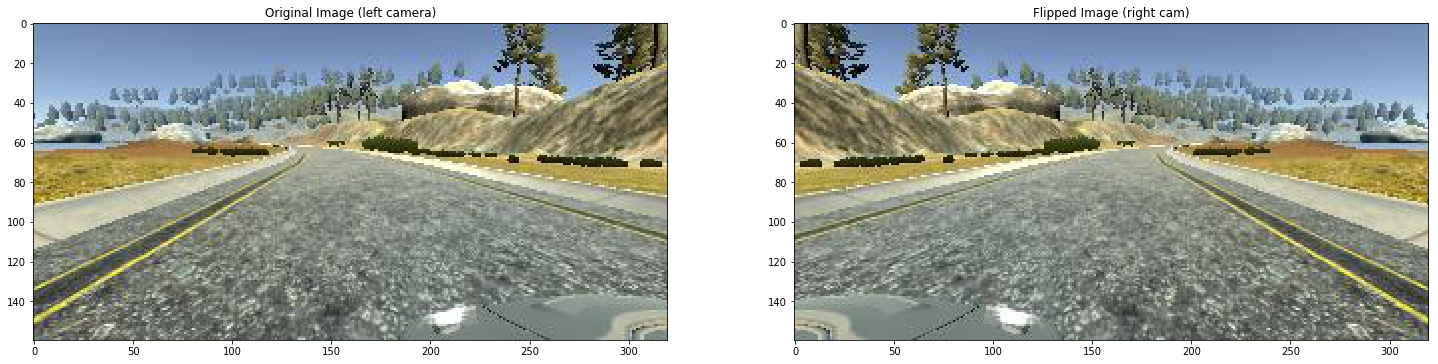

In [7]:
# Flipping turns
def flip(img, steeringAngle):
    '''
    Flip the images and steering angles
    :param img: Image as numpy array
    :param steeringAngle: Steering Angle
    :return: Flipped Image and Angle
    '''
    # numpy function .fliplr() flips an array in the left/right direction
    return np.fliplr(img), -steeringAngle

# take one camera view from the entry i.e. left side
image = cv2.imread(df.iloc[1893]['left cam'].strip())
# change the image from BGR to RGB colour space
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


plt.subplots(figsize=(25,12))
plt.subplot(121)
plt.imshow(image)
plt.title('Original Image (left camera)')
plt.subplot(122)
plt.imshow(flip(image, 0)[0])
plt.title('Flipped Image (right cam)')


Text(0.5,1,'Translated Image')

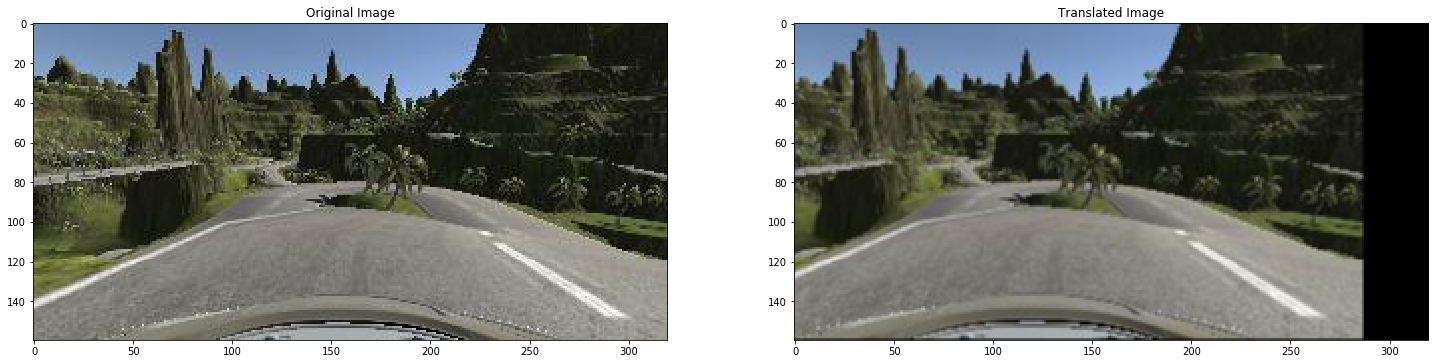

In [8]:
# Translating Images

def translation(image, steering, trans_range_x, trans_range_y):

    #HYPERPARAMETER
    steeringCorrectionPerPixel = 0.008
    num_rows, num_cols = image.shape[:2]
   
    # translation in the x direction
    # (range * random(0-1)) - (range/2)
    # distributes the range randomly either side of 0
    tx = trans_range_x * np.random.uniform() - (trans_range_x / 2)
    
    # translation in the y direction
    # distribute the range randomly either side of 0
    ty = trans_range_y * np.random.uniform() - trans_range_y / 2

    steering = steering + tx / trans_range_x * steeringCorrectionPerPixel

    translation_matrix = np.float32([ [1,0,tx], [0,1,ty] ])
    img_translation = cv2.warpAffine(image, translation_matrix, (num_cols, num_rows))
    return img_translation, steering


#image = cv2.imread(df.loc[100][0].strip())
image = cv2.imread(df.loc[np.random.randint(len(df))][0].strip())
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.subplots(figsize=(25,12))
plt.subplot(121)
plt.imshow(image)
plt.title('Original Image')
plt.subplot(122)
plt.imshow(translation(image, 0, 80, 10)[0])
plt.title('Translated Image')

In [9]:
# Brightness variation
# vary the brightness of images and keep steering angle the same
def brightness(image):
    
    nimage = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    # change from uint8 -> uint32 for varying the brightness
    nimage = nimage.astype(np.uint32) # needed so we can preform operations with floats
    
    random_bright = np.random.uniform() + 0.5 #HYPERPARAMETER + 0.5 to stop the image getting too dark
    nimage[:,:,2] = nimage[:,:,2] * random_bright
    # Cap the brightness values at 255
    nimage[nimage > 255] = 255
    nimage = nimage.astype(np.uint8) # change back to uint8

    nimage = cv2.cvtColor(nimage, cv2.COLOR_HSV2RGB)
    return nimage

Text(0.5,1,'Image with brightness changed')

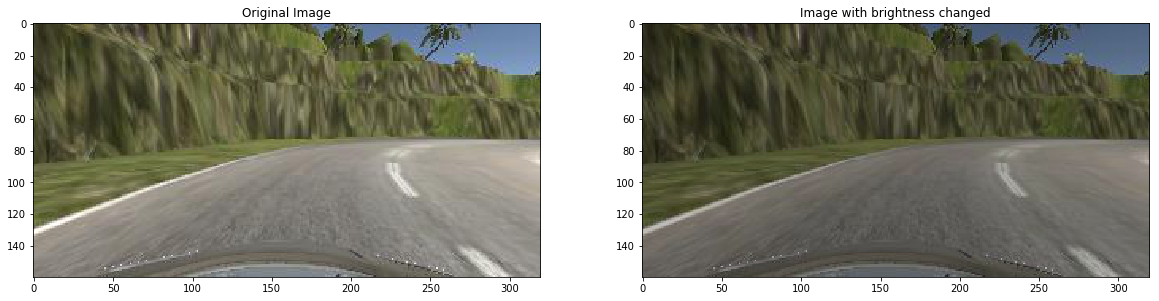

In [10]:
image = cv2.imread(df.loc[660][0].strip())
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.subplots(figsize=(20, 12))
plt.subplot(121)
plt.imshow(image)
plt.title('Original Image')
plt.subplot(122)
plt.imshow(brightness(image))
plt.title('Image with brightness changed')

## Loading Samples

centre cam    C:\Users\Roble\Desktop\SelfDrivingCar\Behaviou...
left cam      C:\Users\Roble\Desktop\SelfDrivingCar\Behaviou...
right cam     C:\Users\Roble\Desktop\SelfDrivingCar\Behaviou...
steering                                               0.276995
throttle                                                      0
brake                                                         0
speed                                                    15.069
Name: 4000, dtype: object


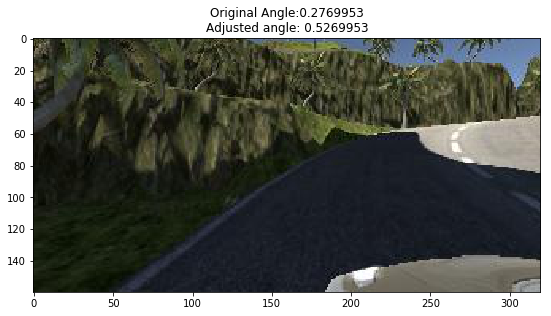

In [11]:
# loading samples from the data set parsing them to the correct form for
# the CNN and augmenting them with the above functions
# steering_offset is a hyperparameter
def load_sample(sample, camera=0, steering_offset=0.25):
    '''
    :pd.Series sample: one element from the data set incl. image path,angles, etc
    :string camera: which camera the image is from
    :int steering_offset: the steering offset for different camera angles 
    :return (ndarray, int): Image, Steering angle
    '''
    path = sample[camera].strip()
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    print(sample)
    steering = sample['steering']
    
    if camera == 1: # left
        steering += steering_offset
    elif camera == 2: # right
        steering -= steering_offset
                       
    return image, steering

# test

sample = df.loc[4000]
plt.subplots(figsize=(20, 12))
plt.subplot(221)
imageAngle = load_sample(sample, 1)
plt.imshow(imageAngle[0])
plt.title('Original Angle:{}\nAdjusted angle: {}'.format(sample['steering'],imageAngle[1]))
assert(sample['steering'] + 0.25 == imageAngle[1])
#assert(sample['left cam'] == (imageAngle[0]))
# lol tried comparing image path to array of pixels need coffee
